In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import time
import tensorflow
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import logging
import math
import os
from sklearn.preprocessing import MinMaxScaler, scale
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import optimizers
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

# 데이터 불러오기 / 데이터 정리

In [3]:
IT_nonfinance = pd.read_excel('./data/dongboo/비재무/IT_비재무_TOTAL_최종.xlsx')
Medicine_nonfinance = pd.read_excel('./data/dongboo/비재무/제약_비재무_TOTAL_최종.xlsx')

In [4]:
Medicine_nonfinance.drop(["근속_연","근속_월"],axis = 1, inplace= True)

In [5]:
# krx에서 가져온 자료
IT_stock = pd.read_excel('./data/dongboo/IT_주가_total_krx.xlsx')
Medicine_stock = pd.read_excel('./data/dongboo/제약_주가_total_krx.xlsx')

# IT_stock = pd.read_excel('./data/dongboo/IT_TOTAL_주가.xlsx')
# Medicine_stock = pd.read_excel('./data/dongboo/제약_TOTAL_주가.xlsx')

In [6]:
IT = pd.merge(IT_nonfinance,IT_stock,how = 'left', on = ['회사명','거래소코드','회계년도'])
Medicine = pd.merge(Medicine_nonfinance,Medicine_stock,how = 'left', on = ['회사명','거래소코드','회계년도'])

In [7]:
IT.columns

Index(['회사명', '거래소코드', '회계년도', '주식의 종류', '발행할 주식의 총수(주)', '현재까지 발행한 주식의 총수(주)', '현재까지 감소한 주식의 총수(주)', '유통주식수 (발행주식의 총수 - 자기주식수)(주)', '이익소각(주)', '발행주식의 총수 (현재 발행한 주식수 - 현재 감소한 주식수)(주)', '자기주식수(주)', '정규+무기계약_기말인원(남)(명)', '정규+무기계약_기말인원(여)(명)', '정규+무기계약_기말인원(명)', '기간제_기말인원(남)(명)', '기간제_기말인원(여)(명)', '기간제_기말인원(명)', '합계_기말인원_남(명)', '합계_기말인원_여(명)', '합계_기말인원(명)', '합계_년간평균급여(천원)', '합계_1인평균년간급여(천원)', '합계_평균근속연수', '최고가', '최저가', '종가', '거래량', '거래대금'], dtype='object')

In [8]:
#del IT['주식매입선택권.1']

# 회사별로 분리

In [9]:
lg = IT[IT['회사명'] == 'LG이노텍(주)']
sdi = IT[IT['회사명'] == '삼성SDI(주)']
ssem = IT[IT['회사명'] == '삼성전기(주)']
hynix = IT[IT['회사명'] == '에스케이하이닉스(주)']

In [10]:
lg

,회사명,거래소코드,회계년도,주식의 종류,발행할 주식의 총수(주),현재까지 발행한 주식의 총수(주),현재까지 감소한 주식의 총수(주),유통주식수 (발행주식의 총수 - 자기주식수)(주),이익소각(주),발행주식의 총수 (현재 발행한 주식수 - 현재 감소한 주식수)(주),자기주식수(주),정규+무기계약_기말인원(남)(명),정규+무기계약_기말인원(여)(명),정규+무기계약_기말인원(명),기간제_기말인원(남)(명),기간제_기말인원(여)(명),기간제_기말인원(명),합계_기말인원_남(명),합계_기말인원_여(명),합계_기말인원(명),합계_년간평균급여(천원),합계_1인평균년간급여(천원),합계_평균근속연수,최고가,최저가,종가,거래량,거래대금
0,LG이노텍(주),11070,2010/03,10,200000000,17131823,0,17129223,0,17131823,2600,0,0,0,0,0,0,6523,6187,12710,86825591,6831,3.00,128500,97800,113150,5785616,644359793314
1,LG이노텍(주),11070,2011/03,10,200000000,20146503,0,20143903,0,20146503,2600,5770,1781,7551,86,241,327,5856,2022,7878,98617000,13000,3.20,126500,112000,119250,5105469,597488403500
2,LG이노텍(주),11070,2012/03,10,200000000,20167963,0,20165363,0,20167963,2600,5890,1709,7599,36,170,206,5926,1879,7805,101397000,13000,5.44,107000,94000,100500,4689082,478587655600
3,LG이노텍(주),11070,2013/03,10,200000000,20170754,0,20168154,0,20170754,2600,6247,1762,8009,1066,351,1417,7313,2113,9426,118026000,13000,4.60,79100,71600,75350,2628498,199385049000
4,LG이노텍(주),11070,2014/03,10,200000000,20288271,0,20285671,0,20288271,2600,6988,1683,8671,78,152,230,7066,1835,8901,131983000,15000,5.70,103000,89500,96250,3130564,306385114000
5,LG이노텍(주),11070,2015/03,10,200000000,23667107,0,23664507,0,23667107,2600,7101,1634,8735,124,127,251,7225,1761,8986,182745000,27000,6.28,116000,102500,109250,4273591,469566045000
6,LG이노텍(주),11070,2016/03,10,200000000,23667107,0,23664507,0,23667107,2600,6838,1522,8360,70,50,120,6908,1572,8480,143947000,17000,7.10,86600,77900,82250,3953705,326948428700
7,LG이노텍(주),11070,2017/03,10,200000000,23667107,0,23664507,0,23667107,2600,6594,1348,7942,158,172,330,6752,1520,8272,127308000,15000,7.60,142000,122000,132000,3996104,527146529413
8,LG이노텍(주),11070,2018/03,10,200000000,23667107,0,23664507,0,23667107,2600,6686,1364,8050,610,246,856,7296,1610,8906,202807000,18000,7.90,137500,120000,128750,5184190,668888538140
33,LG이노텍(주),11070,2010/06,10,200000000,20064406,0,20061806,0,20064406,2600,0,0,0,0,0,0,5001,1496,6497,152043000,23400,3.70,173000,156500,164750,6159012,1009752795890


In [11]:
greencross = Medicine[Medicine['회사명'] == '(주)녹십자']
daewoong = Medicine[Medicine['회사명'] == '(주)대웅제약']
yoohan = Medicine[Medicine['회사명'] == '(주)유한양행']
hanmi = Medicine[Medicine['회사명'] == '한미약품(주)']

In [12]:
def classify(stock):
    
    # 회계년도 순으로 정렬 및 인덱스 초기화
    stock.sort_values('회계년도', ascending= True, inplace = True)
    
    stock.reset_index(drop = True, inplace = True)
    
    
    # 새로운 변수 추가
    
    stock['3개월후종가'] = stock['종가'][1:].reset_index(drop=True)
    
    stock['분기수익률'] = (stock['3개월후종가'] - stock['종가']) / stock['종가']
    
    stock['수익률상승하락'] = stock['분기수익률']
    
    for i in range(len(stock)):
        if stock['분기수익률'][i] < 0.005:
            stock['수익률상승하락'][i] = 0
        else:
            stock['수익률상승하락'][i] = 1
        
       
    return stock

In [13]:
classify(lg)
classify(sdi)
classify(ssem)
classify(hynix)

classify(greencross)
classify(daewoong)
classify(yoohan)
classify(hanmi)

,회사명,거래소코드,회계년도,주식의 종류,발행할 주식의 총수(주),현재까지 발행한 주식의 총수(주),현재까지 감소한 주식의 총수(주),유통주식수 (발행주식의 총수 - 자기주식수)(주),이익소각(주),발행주식의 총수 (현재 발행한 주식수 - 현재 감소한 주식수)(주),자기주식수(주),정규+무기계약_기말인원(남)(명),정규+무기계약_기말인원(여)(명),정규+무기계약_기말인원(명),기간제_기말인원(남)(명),기간제_기말인원(여)(명),기간제_기말인원(명),합계_기말인원_남(명),합계_기말인원_여(명),합계_기말인원(명),합계_년간평균급여(천원),합계_1인평균년간급여(천원),합계_평균근속연수,최고가,최저가,종가,거래량,거래대금,3개월후종가,분기수익률,수익률상승하락
0,한미약품(주),128940,2010/09,10,15000000,7154540,0,7150421,0,7154540,4119,0,0,0,0,0,0,0,0,1917,64121000,33000,5.250000,119000,104000,111500,1298286,147793375500,90800.0,-0.185650,0.0
1,한미약품(주),128940,2010/12,10,16000000,7154540,0,7150421,0,7154540,4119,1438,463,1901,0,0,0,1438,463,1901,92683000,49000,5.480000,96300,85300,90800,1448998,128379414000,81050.0,-0.107379,0.0
2,한미약품(주),128940,2011/03,10,16000000,7512061,0,7504311,0,7512061,7750,1435,467,1902,0,0,0,1435,467,1902,23989086,12613,4.800000,87500,74600,81050,718507,57610507200,73850.0,-0.088834,0.0
3,한미약품(주),128940,2011/06,10,16000000,7512061,0,7504311,0,7512061,7750,1483,459,1942,0,0,0,1483,459,1942,44166000,23000,4.960000,77100,70600,73850,879634,65081187100,75550.0,0.023020,1.0
4,한미약품(주),128940,2011/09,10,16000000,7512061,0,7504311,0,7512061,7750,1499,434,1933,0,0,0,1499,434,1933,62231000,32000,5.070000,83100,68000,75550,304899,22588237200,65400.0,-0.134348,0.0
5,한미약품(주),128940,2011/12,10,16000000,7512061,0,7504311,0,7512061,7750,1490,429,1919,0,0,0,1490,429,1919,83117000,43000,5.250000,68300,62500,65400,462293,30233148400,57100.0,-0.126911,0.0
6,한미약품(주),128940,2012/03,10,25000000,7887276,0,7876819,0,7887276,10457,1573,429,2002,0,0,0,1573,429,2002,24805000,12000,5.166667,60300,53900,57100,491161,27979739700,59600.0,0.043783,1.0
7,한미약품(주),128940,2012/06,10,25000000,7887276,0,7876819,0,7887276,10457,1346,419,1765,0,0,0,1346,419,1765,42675000,24000,5.560000,67100,52100,59600,968824,57979706500,117500.0,0.971477,1.0
8,한미약품(주),128940,2012/12,10,25000000,7887276,0,7876819,0,7887276,10457,1322,411,1733,0,0,0,1322,411,1733,80709000,47000,5.750000,125000,110000,117500,986390,118356257000,159250.0,0.355319,1.0
9,한미약품(주),128940,2013/03,10,25000000,8281116,0,8268121,0,8281116,12995,1324,431,1755,0,0,0,1324,431,1755,22709000,13000,5.750000,166500,152000,159250,846238,134802296500,160500.0,0.007849,1.0


In [14]:
lg = lg.iloc[:-1,:]
sdi = sdi.iloc[:-1,:]
ssem = ssem.iloc[:-1,:]
hynix = hynix.iloc[:-1,:]

greencross = greencross.iloc[:-1,:]
daewoong = daewoong.iloc[:-1,:]
yoohan = yoohan.iloc[:-1,:]
hanmi = hanmi.iloc[:-1,:]

# 산업별 변수 <3개월 후 종가>와의 상관관계 분석

In [15]:
# 밑에 함수로 해보기!!!!

In [16]:
lg_corr = lg.corr(method = 'pearson')
df_lg = pd.DataFrame(lg_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_lg.columns = ['지표','3개월후종가']

sdi_corr = sdi.corr(method = 'pearson')
df_sdi = pd.DataFrame(sdi_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_sdi.columns = ['지표','3개월후종가']

ssem_corr = ssem.corr(method = 'pearson')
df_ssem = pd.DataFrame(ssem_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_ssem.columns = ['지표','3개월후종가']

hynix_corr = hynix.corr(method = 'pearson')
df_hynix = pd.DataFrame(hynix_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_hynix.columns = ['지표','3개월후종가']

# 산업별 상관관계 데이터프레임

In [17]:
pd.concat([df_lg.reset_index(drop = True), df_sdi.reset_index(drop = True), df_ssem.reset_index(drop = True), df_hynix.reset_index(drop = True)],axis = 1)

,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가,지표,3개월후종가
0,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000,3개월후종가,1.000000
1,최고가,0.762866,최고가,0.834369,최고가,0.833189,종가,0.946807
2,종가,0.743054,종가,0.822499,종가,0.819678,최고가,0.946405
3,최저가,0.708172,자기주식수(주),0.811674,최저가,0.796873,최저가,0.942756
4,거래대금,0.680997,최저가,0.794184,거래대금,0.689726,합계_기말인원(명),0.819862
5,거래량,0.591522,거래대금,0.439254,거래량,0.515173,합계_평균근속연수,0.771964
6,분기수익률,0.371931,분기수익률,0.391575,분기수익률,0.355252,기간제_기말인원(명),0.735836
7,합계_기말인원(명),0.280910,합계_평균근속연수,0.380805,정규+무기계약_기말인원(남)(명),0.327852,기간제_기말인원(남)(명),0.719438
8,합계_기말인원_여(명),0.261565,기간제_기말인원(남)(명),0.335863,정규+무기계약_기말인원(명),0.314911,정규+무기계약_기말인원(남)(명),0.686388
9,기간제_기말인원(명),0.235090,수익률상승하락,0.327088,수익률상승하락,0.300441,합계_기말인원_남(명),0.650981


In [18]:
list_corr = []
order = 30 # 기업별로 상위 30개 상관관계 변수 추출

for i in range(len(df_lg.index[:order])):
    list_corr.append(df_lg.index[:order][i])
    list_corr.append(df_sdi.index[:order][i])
    list_corr.append(df_ssem.index[:order][i])
    list_corr.append(df_hynix.index[:order][i])

variable = pd.Series(list_corr).value_counts()
variable = pd.DataFrame(variable).reset_index()
variable.columns = ['var_index', 'number']

In [19]:
var = []
for i in range(len(variable)):
    var.append(df_lg[df_lg.index == variable['var_index'][i]]['지표'].values[0])
var = pd.DataFrame(var)
var.columns = ['var']

In [20]:
corr = pd.concat([variable,var], axis = 1)
corr = corr[['var_index','var','number']]
corr.head(30)

,var_index,var,number
0,28,수익률상승하락,4
1,13,기간제_기말인원(여)(명),4
2,1,주식의 종류,4
3,2,발행할 주식의 총수(주),4
4,3,현재까지 발행한 주식의 총수(주),4
5,4,현재까지 감소한 주식의 총수(주),4
6,5,유통주식수 (발행주식의 총수 - 자기주식수)(주),4
7,6,이익소각(주),4
8,7,발행주식의 총수 (현재 발행한 주식수 - 현재 감소한 주식수)(주),4
9,8,자기주식수(주),4


In [21]:
stop

NameError: name 'stop' is not defined

# 위 자료를 보고 변수 선정

In [54]:
deep_lg = lg[corr['var'][:22]]
deep_sdi = sdi[corr['var'][:22]]
deep_ssem = ssem[corr['var'][:22]]
deep_hynix = hynix[corr['var'][:22]]

deep_lg['수익률상승하락'] = lg['수익률상승하락']
deep_sdi['수익률상승하락'] = sdi['수익률상승하락']
deep_ssem['수익률상승하락'] = ssem['수익률상승하락']
deep_hynix['수익률상승하락'] = hynix['수익률상승하락']

In [55]:
deep_lg.drop(['발행할 주식의 총수(주)', '현재까지 발행한 주식의 총수(주)', '현재까지 감소한 주식의 총수(주)',
                         '정규+무기계약_기말인원(남)(명)', '정규+무기계약_기말인원(여)(명)', '기간제_기말인원(남)(명)',
                         '합계_기말인원_남(명)', '합계_기말인원_여(명)','합계_기말인원(명)'], axis = 1, inplace = True)
deep_sdi.drop(['발행할 주식의 총수(주)', '현재까지 발행한 주식의 총수(주)', '현재까지 감소한 주식의 총수(주)',
                         '정규+무기계약_기말인원(남)(명)', '정규+무기계약_기말인원(여)(명)', '기간제_기말인원(남)(명)',
                         '합계_기말인원_남(명)', '합계_기말인원_여(명)','합계_기말인원(명)'], axis = 1, inplace = True)
deep_ssem.drop(['발행할 주식의 총수(주)', '현재까지 발행한 주식의 총수(주)', '현재까지 감소한 주식의 총수(주)',
                         '정규+무기계약_기말인원(남)(명)', '정규+무기계약_기말인원(여)(명)', '기간제_기말인원(남)(명)',
                         '합계_기말인원_남(명)', '합계_기말인원_여(명)','합계_기말인원(명)'], axis = 1, inplace = True)
deep_hynix.drop(['발행할 주식의 총수(주)', '현재까지 발행한 주식의 총수(주)', '현재까지 감소한 주식의 총수(주)',
                         '정규+무기계약_기말인원(남)(명)', '정규+무기계약_기말인원(여)(명)', '기간제_기말인원(남)(명)',
                         '합계_기말인원_남(명)', '합계_기말인원_여(명)','합계_기말인원(명)'], axis = 1, inplace = True)

In [56]:
# 표준화

from sklearn.preprocessing import StandardScaler

scaler_lg = StandardScaler()
scale_lg = pd.DataFrame(scaler_lg.fit_transform(deep_lg.iloc[:,:-1]))

scaler_sdi = StandardScaler()
scale_sdi = pd.DataFrame(scaler_sdi.fit_transform(deep_sdi.iloc[:,:-1]))

scaler_ssem = StandardScaler()
scale_ssem = pd.DataFrame(scaler_ssem.fit_transform(deep_ssem.iloc[:,:-1]))

scaler_hynix = StandardScaler()
scale_hynix = pd.DataFrame(scaler_hynix.fit_transform(deep_hynix.iloc[:,:-1]))

# 원래 값으로 변환
# scaler_lg.inverse_transform(scale_lg)

In [57]:
# deep_IT = deep_IT.drop(['발행할 주식의 총수(주)', '현재까지 발행한 주식의 총수(주)', '현재까지 감소한 주식의 총수(주)',
#                         '정규+무기계약_기말인원(남)(명)', '정규+무기계약_기말인원(여)(명)', '기간제_기말인원(남)(명)',
#                         '합계_기말인원_남(명)', '합계_기말인원_여(명)'], axis = 1)
# deep_IT = deep_IT.drop('합계_기말인원(명)', axis = 1)

In [58]:
# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_IT = pd.concat([deep_lg,deep_sdi,deep_ssem,deep_hynix], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_IT = pd.concat([scale_lg,scale_sdi,scale_ssem,scale_hynix], ignore_index=True)

scale_IT

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.164965,-1.043736,0.0,-2.475075,0.0,-2.475075,0.000000,-3.114603,-0.771584,2.102144,-1.443375,-1.725565
1,-0.858395,-1.043736,0.0,-0.944885,0.0,-0.944885,0.000000,-3.114603,-0.771584,-0.867527,-0.980183,-0.630748
2,-0.858395,-1.043736,0.0,-0.917002,0.0,-0.917002,0.000000,-3.114603,-0.771584,-0.414529,-0.482810,-0.042669
3,-0.858395,-0.154239,0.0,-0.912236,0.0,-0.912236,0.000000,-0.011899,-0.403599,-0.581253,0.590437,0.994728
4,-0.858395,-0.051288,0.0,-0.902047,0.0,-0.902047,0.000000,0.046288,-0.401335,-1.056186,-1.359629,-1.317940
5,-0.858395,-0.080115,0.0,-0.895534,0.0,-0.895534,0.000000,0.106567,-0.421715,-1.801179,-0.671191,-0.591102
6,1.164965,-0.080115,0.0,-0.895504,0.0,-0.895504,0.000000,0.109497,-0.452286,0.401418,-0.029698,0.201813
7,1.164965,-0.253072,0.0,-0.895504,0.0,-0.895504,0.000000,0.054660,-0.515693,1.972934,0.651375,0.994728
8,-0.858395,-0.343669,0.0,-0.890850,0.0,-0.890850,0.000000,0.066381,-0.538338,-1.008501,-1.339885,-1.317940
9,1.164965,-0.318961,0.0,-0.890842,0.0,-0.890842,0.000000,0.068892,-0.379822,-0.043015,-0.646425,-0.525026


In [59]:
scale_IT.corr()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,-0.098153,NaN,-0.078024,NaN,-0.028382,0.132066,-0.001374,-0.061753,0.791590,-0.062617,-0.063216
1,-0.098153,1.000000,NaN,0.109691,NaN,0.127798,0.125549,0.345395,0.860678,-0.144834,0.258706,0.171090
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.078024,0.109691,NaN,1.000000,NaN,0.864305,-0.299802,0.497097,0.143083,-0.073129,0.306899,0.194188
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-0.028382,0.127798,NaN,0.864305,NaN,1.000000,0.070161,0.581518,0.173417,0.001938,0.368811,0.256791
6,0.132066,0.125549,NaN,-0.299802,NaN,0.070161,1.000000,0.029400,0.317436,0.202488,0.078369,0.132243
7,-0.001374,0.345395,NaN,0.497097,NaN,0.581518,0.029400,1.000000,0.283750,0.050844,0.258144,0.125669
8,-0.061753,0.860678,NaN,0.143083,NaN,0.173417,0.317436,0.283750,1.000000,-0.052050,0.263014,0.192213
9,0.791590,-0.144834,NaN,-0.073129,NaN,0.001938,0.202488,0.050844,-0.052050,1.000000,0.005944,0.006056


In [60]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import matplotlib
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

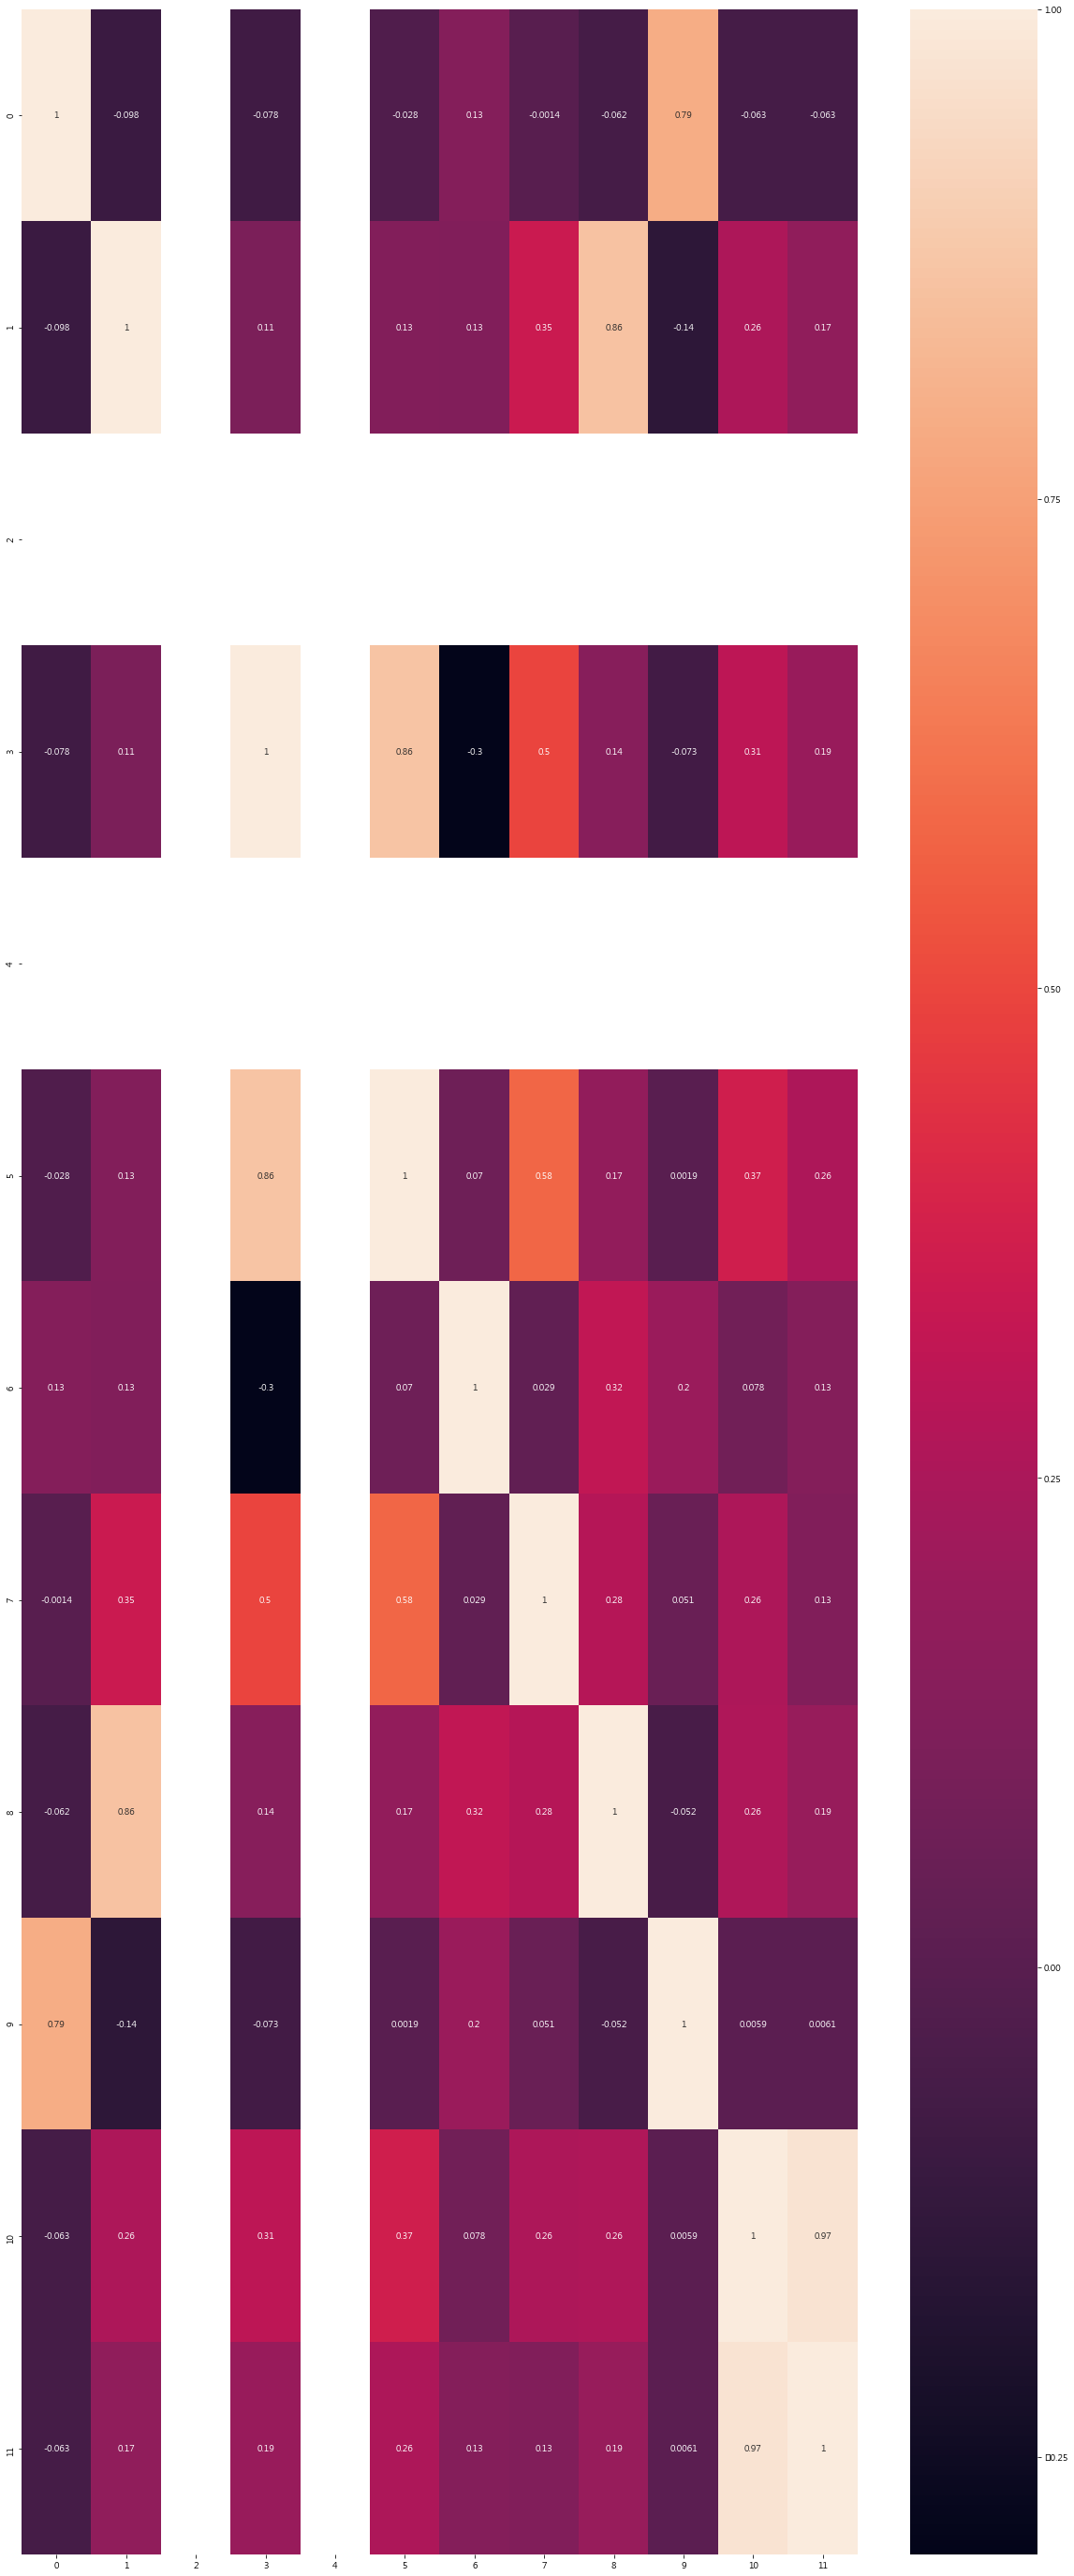

In [61]:
plt.figure(figsize=(20,50))

sns.heatmap(data = scale_IT.corr(), annot = True)
# plt.savefig('tmp.png')

In [62]:
scale_IT = scale_IT.drop([2,4,6],axis = 1)

In [63]:
scale_IT.head() 

,0,1,3,5,7,8,9,10,11
0,1.164965,-1.043736,-2.475075,-2.475075,-3.114603,-0.771584,2.102144,-1.443375,-1.725565
1,-0.858395,-1.043736,-0.944885,-0.944885,-3.114603,-0.771584,-0.867527,-0.980183,-0.630748
2,-0.858395,-1.043736,-0.917002,-0.917002,-3.114603,-0.771584,-0.414529,-0.482810,-0.042669
3,-0.858395,-0.154239,-0.912236,-0.912236,-0.011899,-0.403599,-0.581253,0.590437,0.994728
4,-0.858395,-0.051288,-0.902047,-0.902047,0.046288,-0.401335,-1.056186,-1.359629,-1.317940


# 샤비어함수 및 히든레이어 5개

# 및 Validation

In [70]:
# Review : Learning rate and Evaluation
import tensorflow as tf
import random
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility
tf.reset_default_graph()


x_data = scale_IT.iloc[:,:-1]
y_data = deep_IT.iloc[:,[-1]]


# parameters
placeholder_num = len(x_data.columns)
learning_rate = 0.000001




X = tf.placeholder(tf.float32, [None, placeholder_num])
Y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)


W1 = tf.get_variable("W1", shape=[placeholder_num, 32], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([32]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


W2 = tf.get_variable("W2", shape=[32, 64], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([64]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable("W3", shape=[64, 64], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([64]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


W4 = tf.get_variable("W4", shape=[64, 32], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([32]))
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)


W5 = tf.get_variable("W5", shape=[32, 1], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([1]))
L5 = tf.nn.relu(tf.matmul(L4, W5) + b5)

# hypothesis = tf.matmul(L4, W5) + b5

# define cost/loss & optimizer

# Hypothesis using sigmoid: tf.div(1., 1. + tf.exp(tf.matmul(X, W)))
hypothesis = tf.sigmoid(tf.matmul(L4,W5) + b5)

# cost/loss function
cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
                       tf.log(1 - hypothesis))

train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# train = tf.train.AdamOptimizer(1e-4).minimize(cost)

# Accuracy computation
# True if hypothesis>0.5 else False
predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

In [71]:
# Launch graph

validation_number = 20
#init_state = lstm_cell.zero_state(128, tf.float32)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(5001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data.iloc[:-validation_number,:], Y: y_data.iloc[:-validation_number,:], keep_prob: 0.8})       
        if step % 200 == 0 or step < 10 :
            print("Step : {} \t Cost : {}".format(step, cost_val))    

    # Accuracy report
    h, c, a = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_data.iloc[-validation_number:,:], Y: y_data.iloc[-validation_number:,:], keep_prob: 1.0})

Step : 0 	 Cost : 17.933338165283203
Step : 1 	 Cost : 18.326826095581055
Step : 2 	 Cost : 17.443405151367188
Step : 3 	 Cost : 15.536046981811523
Step : 4 	 Cost : 17.78993034362793
Step : 5 	 Cost : 19.37310218811035
Step : 6 	 Cost : 19.26127052307129
Step : 7 	 Cost : 18.74050521850586
Step : 8 	 Cost : 18.286155700683594
Step : 9 	 Cost : 17.41307830810547
Step : 200 	 Cost : 14.604397773742676
Step : 400 	 Cost : 15.359642028808594
Step : 600 	 Cost : 12.637145042419434
Step : 800 	 Cost : 11.633475303649902
Step : 1000 	 Cost : 9.093570709228516
Step : 1200 	 Cost : 10.427061080932617
Step : 1400 	 Cost : 6.689227104187012
Step : 1600 	 Cost : 5.867940425872803
Step : 1800 	 Cost : 5.54478645324707
Step : 2000 	 Cost : 0.9630163311958313
Step : 2200 	 Cost : -0.47385069727897644
Step : 2400 	 Cost : -2.104983329772949
Step : 2600 	 Cost : -1.2912330627441406
Step : 2800 	 Cost : -3.283451557159424
Step : 3000 	 Cost : -5.5690155029296875
Step : 3200 	 Cost : -7.3217034339904785

In [75]:
print('모델 정확도: ', a * 100 , '%')

모델 정확도:  0.0 %


In [73]:
# pd.DataFrame(y_data.iloc[-validation_number:,:].values, c.ravel()).reset_index()
pd.DataFrame({'real':list(y_data.iloc[-validation_number:,:].values.ravel()),'predict': list(c.ravel())})

,real,predict
0,9.00,1.0
1,9.30,1.0
2,9.20,1.0
3,9.50,1.0
4,9.50,1.0
5,10.00,1.0
6,10.00,1.0
7,9.80,1.0
8,10.00,1.0
9,10.20,1.0


In [74]:
h # hypothesis

array([[0.94519335],
       [0.9408558 ],
       [0.94674623],
       [0.93710953],
       [0.9429917 ],
       [0.94180995],
       [0.94122326],
       [0.9362039 ],
       [0.9360823 ],
       [0.94141686],
       [0.9314167 ],
       [0.9459212 ],
       [0.9445548 ],
       [0.9444134 ],
       [0.94664556],
       [0.9453693 ],
       [0.9402352 ],
       [0.94232625],
       [0.9404968 ],
       [0.93778956]], dtype=float32)

# 제약

In [ ]:
greencross_corr = greencross.corr(method = 'pearson')
df_greencross = pd.DataFrame(lg_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_greencross.columns = ['지표','3개월후종가']

daewoong_corr = daewoong.corr(method = 'pearson')
df_daewoong = pd.DataFrame(daewoong_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_daewoong.columns = ['지표','3개월후종가']

yoohan_corr = ssem.corr(method = 'pearson')
df_yoohan = pd.DataFrame(yoohan_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_yoohan.columns = ['지표','3개월후종가']

hanmi_corr = hanmi.corr(method = 'pearson')
df_hanmi = pd.DataFrame(hanmi_corr['3개월후종가']).reset_index().sort_values('3개월후종가', ascending = False)
df_hanmi.columns = ['지표','3개월후종가']

In [ ]:
pd.concat([df_greencross.reset_index(drop = True), df_daewoong.reset_index(drop = True),
           df_yoohan.reset_index(drop = True), df_hanmi.reset_index(drop = True)],axis = 1)

In [ ]:
list_corr = []
order = 15 # 기업별로 상위 30개 상관관계 변수 추출

for i in range(len(df_greencross.index[:order])):
    list_corr.append(df_greencross.index[:order][i])
    list_corr.append(df_daewoong.index[:order][i])
    list_corr.append(df_yoohan.index[:order][i])
    list_corr.append(df_hanmi.index[:order][i])

variable = pd.Series(list_corr).value_counts()
variable = pd.DataFrame(variable).reset_index()
variable.columns = ['var_index', 'number']

In [ ]:
var = []
for i in range(len(variable)):
    var.append(df_greencross[df_greencross.index == variable['var_index'][i]]['지표'].values[0])
var = pd.DataFrame(var)
var.columns = ['var']

In [ ]:
deep_greencross = greencross[corr['var'][3:22]]
deep_yoohan = yoohan[corr['var'][3:22]]
deep_daewoong = daewoong[corr['var'][3:22]]
deep_hanmi = hanmi[corr['var'][3:22]]

deep_greencross['수익률상승하락'] = greencross['수익률상승하락']
deep_yoohan['수익률상승하락'] = yoohan['수익률상승하락']
deep_daewoong['수익률상승하락'] = daewoong['수익률상승하락']
deep_hanmi['수익률상승하락'] = hanmi['수익률상승하락']

In [ ]:
# import re

In [ ]:
# 표준화

from sklearn.preprocessing import StandardScaler

scaler_greencross = StandardScaler()
scale_greencross = pd.DataFrame(scaler_greencross.fit_transform(deep_greencross.iloc[:,:-1]))

scaler_yoohan = StandardScaler()
scale_yoohan = pd.DataFrame(scaler_yoohan.fit_transform(deep_yoohan.iloc[:,:-1]))

scaler_daewoong = StandardScaler()
scale_daewoong = pd.DataFrame(scaler_daewoong.fit_transform(deep_daewoong.iloc[:,:-1]))

scaler_hanmi = StandardScaler()
scale_hanmi = pd.DataFrame(scaler_hanmi.fit_transform(deep_hanmi.iloc[:,:-1]))

# 원래 값으로 변환
# scaler_lg.inverse_transform(scale_lg)

In [ ]:
# 주가를 합치려고 만듬(마지막 열을 가져오면 됨)
deep_Medicine = pd.concat([deep_greencross,deep_yoohan,deep_daewoong,deep_hanmi], ignore_index=True)

# 표준화한 변수를 합치려고 만듬
scale_Medicine = pd.concat([scale_greencross,scale_yoohan,scale_daewoong,scale_hanmi], ignore_index=True)

scale_Medicine

In [ ]:
scale_Medicine.corr()

In [ ]:
plt.figure(figsize=(20,50))

sns.heatmap(data = scale_Medicine.corr(), annot = True)
# plt.savefig('tmp.png')

In [ ]:
scale_Medicine = scale_Medicine.drop([2,4],axis = 1)

In [ ]:
# Review : Learning rate and Evaluation
import tensorflow as tf
import random
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility
tf.reset_default_graph()


x_data = scale_Medicine.iloc[:,:-1]
y_data = deep_Medicine.iloc[:,[-1]]


# parameters
placeholder_num = len(x_data.columns)
learning_rate = 0.001




X = tf.placeholder(tf.float32, [None, placeholder_num])
Y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)


W1 = tf.get_variable("W1", shape=[placeholder_num, 32], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([32]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)


W2 = tf.get_variable("W2", shape=[32, 64], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([64]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable("W3", shape=[64, 64], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([64]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


W4 = tf.get_variable("W4", shape=[64, 32], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([32]))
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)


W5 = tf.get_variable("W5", shape=[32, 1], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([1]))
L5 = tf.nn.relu(tf.matmul(L4, W5) + b5)

# hypothesis = tf.matmul(L4, W5) + b5

# define cost/loss & optimizer

# Hypothesis using sigmoid: tf.div(1., 1. + tf.exp(tf.matmul(X, W)))
hypothesis = tf.sigmoid(tf.matmul(L4,W5) + b5)

# cost/loss function
cost = -tf.reduce_mean(Y * tf.log(hypothesis) + (1 - Y) *
                       tf.log(1 - hypothesis))

train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
# train = tf.train.AdamOptimizer(1e-4).minimize(cost)

# Accuracy computation
# True if hypothesis>0.5 else False
predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, Y), dtype=tf.float32))

In [ ]:
# Launch graph

validation_number = 20
#init_state = lstm_cell.zero_state(128, tf.float32)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    
    sess.run(tf.global_variables_initializer())

    for step in tqdm_notebook(range(5001)):
        cost_val, _ = sess.run([cost, train], feed_dict={X: x_data.iloc[:-validation_number,:], Y: y_data.iloc[:-validation_number,:], keep_prob: 0.8})       
        if step % 200 == 0 or step < 10 :
            print("Step : {} \t Cost : {}".format(step, cost_val))    

    # Accuracy report
    h1, c1, a1 = sess.run([hypothesis, predicted, accuracy],
                       feed_dict={X: x_data.iloc[-validation_number:,:], Y: y_data.iloc[-validation_number:,:], keep_prob: 1.0})

In [ ]:
print('모델 정확도: ', a1 * 100 , '%')

In [ ]:
# pd.DataFrame(y_data.iloc[-validation_number:,:].values, c.ravel()).reset_index()
pd.DataFrame({'real':list(y_data.iloc[-validation_number:,:].values.ravel()),'predict': list(c1.ravel())})

In [ ]:
h1